In [1]:
import mlflow
import pandas as pd
import numpy as np

from pmdarima import auto_arima

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from prophet import Prophet
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
     
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

In [2]:
raw_pjme = pd.read_csv("../data/raw/PJME_hourly.csv", index_col=[0],parse_dates=[0])
#raw_pjme = pd.read_csv("../data/raw/PJME_hourly.csv")

In [3]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [4]:
#raw_pjme["Datetime"] = pd.to_datetime(raw_pjme["Datetime"])

In [5]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [6]:
raw_pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [7]:
raw_pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


<Axes: xlabel='Datetime', ylabel='PJME_MW'>

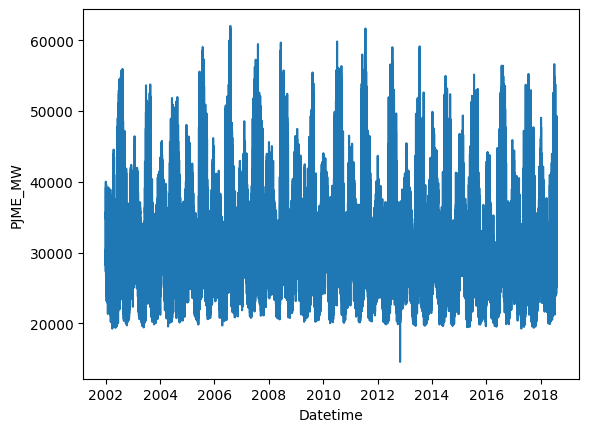

In [8]:
sns.lineplot(x=raw_pjme.index, y=raw_pjme["PJME_MW"])

In [9]:
scaler = StandardScaler()

In [10]:
scaled_array = scaler.fit_transform(raw_pjme)

In [11]:
scaled_array

array([[-0.8635878 ],
       [-1.07259184],
       [-1.16123678],
       ...,
       [ 1.59681207],
       [ 1.25058629],
       [ 1.00986809]])

In [12]:
df_scaled = pd.DataFrame(scaled_array, columns=raw_pjme.columns, index=raw_pjme.index)

In [13]:
df_scaled

,PJME_MW
Datetime,
2002-12-31 01:00:00,-0.863588
2002-12-31 02:00:00,-1.072592
2002-12-31 03:00:00,-1.161237
2002-12-31 04:00:00,-1.189238
2002-12-31 05:00:00,-1.116992
...,...
2018-01-01 20:00:00,1.887964
2018-01-01 21:00:00,1.805507
2018-01-01 22:00:00,1.596812


In [14]:
df_scaled.describe()

,PJME_MW
count,1.453660e+05
mean,2.252371e-16
std,1.000003e+00
min,-2.712910e+00
25%,-6.972818e-01
50%,-1.019839e-01
75%,5.522560e-01
max,4.630078e+00


<Axes: xlabel='Datetime', ylabel='PJME_MW'>

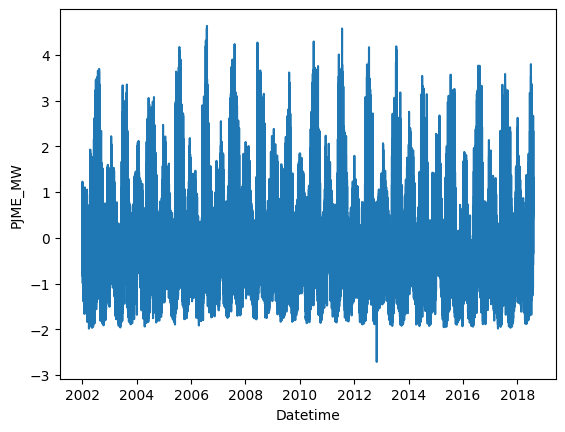

In [15]:
sns.lineplot(x=df_scaled.index, y=df_scaled["PJME_MW"])

In [16]:
raw_pjme.index.duplicated().any()

True

In [17]:
mask = raw_pjme.index.duplicated(keep=False)  
df_dupes = raw_pjme[mask]

In [18]:
df_dupes

,PJME_MW
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


In [19]:
mask = df_scaled.index.duplicated(keep=False)  
df_dupes = df_scaled[mask]

In [20]:
df_dupes

,PJME_MW
Datetime,
2014-11-02 02:00:00,-1.414795
2014-11-02 02:00:00,-1.287939
2015-11-01 02:00:00,-1.626429
2015-11-01 02:00:00,-1.687692
2016-11-06 02:00:00,-1.745860
2016-11-06 02:00:00,-1.607091
2017-11-05 02:00:00,-1.677636
2017-11-05 02:00:00,-1.765817


In [21]:
if raw_pjme.index.duplicated().any():
    raw_pjme = raw_pjme.groupby(level=0).mean().sort_index()

In [22]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145362 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [37]:
raw_pjme = raw_pjme.asfreq("h")

In [38]:
raw_pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [39]:
print(raw_pjme.isna().sum())


PJME_MW    30
dtype: int64


In [40]:
df_nan = raw_pjme[raw_pjme.isna().any(axis=1)]
print(df_nan.head())

                     PJME_MW
Datetime                    
2002-04-07 03:00:00      NaN
2002-10-27 02:00:00      NaN
2003-04-06 03:00:00      NaN
2003-10-26 02:00:00      NaN
2004-04-04 03:00:00      NaN


In [45]:
raw_pjme["PJME_MW"] = raw_pjme["PJME_MW"].interpolate()

In [46]:
df_nan = raw_pjme[raw_pjme.isna().any(axis=1)]
print(df_nan.head())

Empty DataFrame
Columns: [PJME_MW]
Index: []


In [48]:
raw_pjme = raw_pjme.sort_index()

<Axes: xlabel='Datetime', ylabel='PJME_MW'>

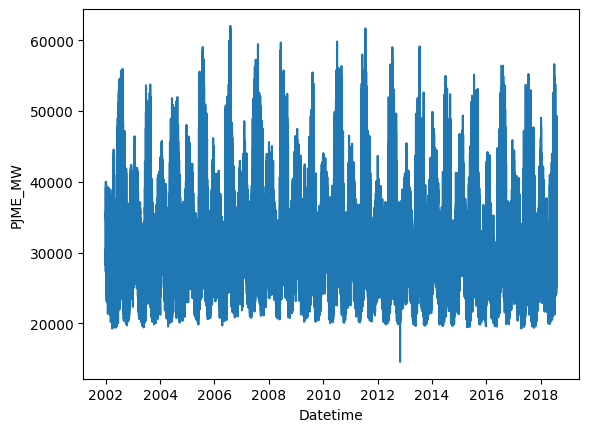

In [49]:
sns.lineplot(x=raw_pjme.index, y=raw_pjme["PJME_MW"])